<a href="https://colab.research.google.com/github/sheyhusna/lotus-checkout-simulation/blob/main/Lotus_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

**Load Data**

In [ ]:
# Load the data
df = pd.read_csv('SIM_Lotus_ObservationSheetcsv.csv')

print("=== DATA LOADING AND INITIAL INSPECTION ===")
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())

=== DATA LOADING AND INITIAL INSPECTION ===
Dataset shape: (95, 15)

First few rows:
  Observer Name Customer ID  \
0         Hanim          H1   
1         Hanim          H3   
2         Izzah          I2   
3        Maryam          M1   
4        Maryam          M2   

   Queue Length When Joined (number of customer in front)  Counter Number  \
0                                                0.0                  4.0   
1                                                0.0                  4.0   
2                                                1.0                  4.0   
3                                                0.0                 10.0   
4                                                2.0                 10.0   

  Counter Type Basket Type Time Enter Queue Time Reached Counter  \
0       Normal     Trolley            15:32                15:32   
1       Normal     Trolley            15:35                15:35   
2       Normal      Basket            15:35                15

In [ ]:
print("\n=== DATA QUALITY CHECK ===")
print("Column information:")
print(df.info())
print("\nMissing values per column:")
print(df.isnull().sum())


=== DATA QUALITY CHECK ===
Column information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 15 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Observer Name                                           95 non-null     object 
 1   Customer ID                                             94 non-null     object 
 2   Queue Length When Joined (number of customer in front)  94 non-null     float64
 3   Counter Number                                          94 non-null     float64
 4   Counter Type                                            94 non-null     object 
 5   Basket Type                                             94 non-null     object 
 6   Time Enter Queue                                        95 non-null     object 
 7   Time Reached Counter                                    94 non-null     object 

# **Data Cleaning**

In [ ]:
print("\n=== DATA CLEANING ===")

# Create a copy for cleaning
df_clean = df.copy()

# Remove rows with any missing values, ignoring 'Customer Behavior / Notes' column
cols_to_consider = df_clean.columns.difference(['Customer Behavior / Notes'])
df_clean = df_clean.dropna(subset=cols_to_consider)

# Handle the missing value in 'Customer Behavior / Notes'
df_clean['Customer Behavior / Notes'].fillna('Normal', inplace=True)

# Convert time columns to datetime
def convert_time(time_str):
    if pd.isna(time_str) or time_str == '':
        return pd.NaT
    try:
        return pd.to_datetime(time_str, format='%H:%M')
    except:
        return pd.NaT

time_columns = ['Time Enter Queue', 'Time Reached Counter', 'Time Service Started', 'Time Service Ended']
for col in time_columns:
    df_clean[col] = df_clean[col].apply(convert_time)

# Calculate duration in minutes
def calculate_duration_minutes(start, end):
    if pd.isna(start) or pd.isna(end):
        return np.nan
    try:
        duration = end - start
        return duration.total_seconds() / 60
    except:
        return np.nan

# Calculate actual waiting time (queue to service start)
df_clean['Actual Waiting Time (mins)'] = df_clean.apply(
    lambda x: calculate_duration_minutes(x['Time Reached Counter'], x['Time Service Started']), axis=1
)

# Calculate actual service time (service start to end)
df_clean['Actual Service Time (mins)'] = df_clean.apply(
    lambda x: calculate_duration_minutes(x['Time Service Started'], x['Time Service Ended']), axis=1
)

# Calculate total time in system (queue entry to service end)
df_clean['Total Time in System (mins)'] = df_clean.apply(
    lambda x: calculate_duration_minutes(x['Time Enter Queue'], x['Time Service Ended']), axis=1
)


# Clean numeric columns
df_clean['Queue Length When Joined (number of customer in front)'] = pd.to_numeric(df_clean['Queue Length When Joined (number of customer in front)'], errors='coerce')
df_clean['Number of Staff'] = pd.to_numeric(df_clean['Number of Staff'], errors='coerce')


# Remove extreme outliers in time columns
time_cols_to_clean = ['Waiting Time (mins)', 'Service Time (mins)', 'Actual Waiting Time (mins)', 'Actual Service Time (mins)']
for col in time_cols_to_clean:
    if col in df_clean.columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean[col] = df_clean[col].clip(lower=lower_bound, upper=upper_bound)


print("Data cleaning completed!")
print(f"Cleaned dataset shape: {df_clean.shape}")


=== DATA CLEANING ===
Data cleaning completed!
Cleaned dataset shape: (93, 18)


In [ ]:
#view cleaned df
df_clean

,Observer Name,Customer ID,Queue Length When Joined (number of customer in front),Counter Number,Counter Type,Basket Type,Time Enter Queue,Time Reached Counter,Time Service Started,Time Service Ended,Number of Staff,Payment Method,Waiting Time (mins),Service Time (mins),Customer Behavior / Notes,Actual Waiting Time (mins),Actual Service Time (mins),Total Time in System (mins)
0,Hanim,H1,0.0,4.0,Normal,Trolley,1900-01-01 15:32:00,1900-01-01 15:32:00,1900-01-01 15:32:00,1900-01-01 15:33:00,1.0,DuitNow,0.0,1.0,Normal,0.0,1.0,1.0
1,Hanim,H3,0.0,4.0,Normal,Trolley,1900-01-01 15:35:00,1900-01-01 15:35:00,1900-01-01 15:35:00,1900-01-01 15:36:00,1.0,Card,0.0,1.0,Normal,0.0,1.0,1.0
2,Izzah,I2,1.0,4.0,Normal,Basket,1900-01-01 15:35:00,1900-01-01 15:35:00,1900-01-01 15:36:00,1900-01-01 15:36:00,1.0,DuitNow,1.0,0.0,Normal,1.0,0.0,1.0
3,Maryam,M1,0.0,10.0,MyKasih,Trolley,1900-01-01 15:36:00,1900-01-01 15:36:00,1900-01-01 15:36:00,1900-01-01 15:37:00,1.0,Cash,0.0,1.0,Normal,0.0,1.0,1.0
4,Maryam,M2,2.0,10.0,MyKasih,Trolley,1900-01-01 15:36:00,1900-01-01 15:38:00,1900-01-01 15:38:00,1900-01-01 15:42:00,1.0,Cash,2.0,4.0,Add last minute stuffs,0.0,4.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,Hanim,H30,1.0,4.0,Normal,Trolley,1900-01-01 17:03:00,1900-01-01 17:04:00,1900-01-01 17:04:00,1900-01-01 17:06:00,1.0,Card,1.0,2.0,Normal,0.0,2.0,3.0
90,Yasmeen,Y14,1.0,11.0,MyKasih,Trolley,1900-01-01 17:02:00,1900-01-01 17:02:00,1900-01-01 17:03:00,1900-01-01 17:06:00,1.0,Cash,1.0,3.0,Normal,1.0,3.0,4.0
91,Hanim,H29,1.0,4.0,Normal,Trolley,1900-01-01 17:03:00,1900-01-01 17:03:00,1900-01-01 17:03:00,1900-01-01 17:03:00,1.0,Card,0.0,0.0,Normal,0.0,0.0,0.0
92,Izzah,I25,2.0,4.0,Normal,Mini Trolley,1900-01-01 17:05:00,1900-01-01 17:05:00,1900-01-01 17:06:00,1900-01-01 17:07:00,1.0,DuitNow,1.0,1.0,Normal,1.0,1.0,2.0


# **Descriptive Statistics**

In [ ]:
print("\n=== BASIC DESCRIPTIVE STATISTICS ===")
print("Numerical columns summary:")
print(df_clean.describe())

print("\nCategorical columns summary:")
categorical_cols = ['Counter Type', 'Basket Type', 'Payment Method', 'Customer Behavior / Notes']
for col in categorical_cols:
    if col in df_clean.columns:
        print(f"\n{col}:")
        print(df_clean[col].value_counts())



=== BASIC DESCRIPTIVE STATISTICS ===
Numerical columns summary:
       Queue Length When Joined (number of customer in front)  Counter Number  \
count                                          93.000000            93.000000   
mean                                            1.354839             7.333333   
min                                             0.000000             4.000000   
25%                                             1.000000             4.000000   
50%                                             1.000000            10.000000   
75%                                             2.000000            11.000000   
max                                             4.000000            11.000000   
std                                             0.880281             3.334058   

                    Time Enter Queue           Time Reached Counter  \
count                             93                             93   
mean   1900-01-01 16:15:43.225806336  1900-01-01 16:16:51.61290

In [ ]:
print("\n=== COUNTER ANALYSIS ===")
counter_stats = df_clean.groupby(['Counter Number', 'Counter Type']).agg({
    'Customer ID': 'count',
    'Waiting Time (mins)': ['mean', 'median', 'max'],
    'Service Time (mins) ': ['mean', 'median', 'max'],
    'Queue Length When Joined (number of customer in front)': ['mean', 'max'],
    'Number of Staff': 'mean'
}).round(2)

print("Counter-wise performance:")
print(counter_stats)



=== COUNTER ANALYSIS ===
Counter-wise performance:
                            Customer ID Waiting Time (mins)              \
                                  count                mean median  max   
Counter Number Counter Type                                               
4.0            Normal                46                1.45    1.0  7.5   
10.0           MyKasih               19                1.58    2.0  5.0   
11.0           MyKasih               28                2.55    3.0  7.5   

                            Service Time (mins)                \
                                            mean median   max   
Counter Number Counter Type                                     
4.0            Normal                       1.33    1.0   7.0   
10.0           MyKasih                      2.21    2.0   6.0   
11.0           MyKasih                      3.04    2.5  12.0   

                            Queue Length When Joined (number of customer in front)  \
                    

# **Exploratory Data Analysis**



1.   Customer distribution by counter type
2.   Average waiting time by counter
3.   Average service time by counter
4.   Basket type analysis
5.   Payment method distribution
6.   Queue length distribution




=== EXPLORATORY DATA ANALYSIS ===


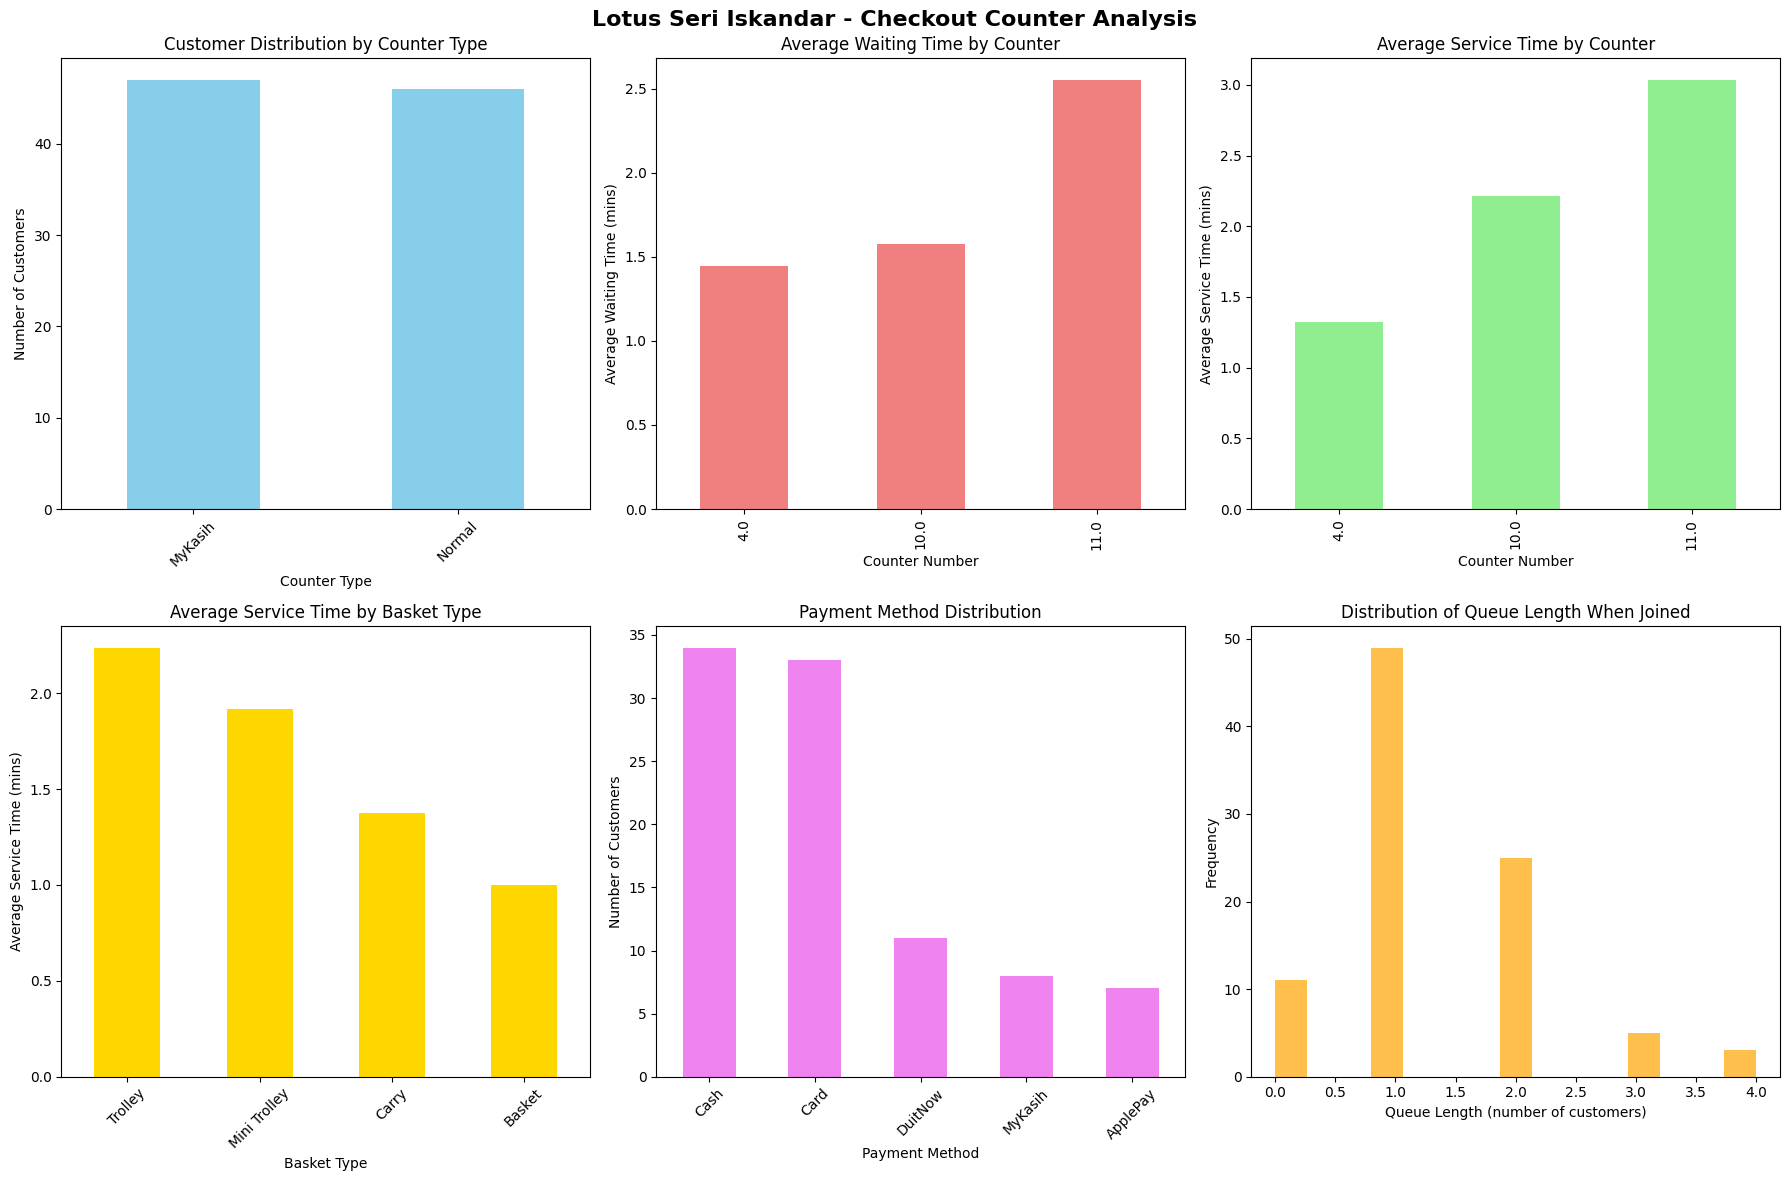

In [ ]:
print("\n=== EXPLORATORY DATA ANALYSIS ===")

# Set up the plotting framework
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Lotus Seri Iskandar - Checkout Counter Analysis', fontsize=16, fontweight='bold')

# 1. Customer distribution by counter type
if 'Counter Type' in df_clean.columns:
    df_clean['Counter Type'].value_counts().plot(kind='bar', ax=axes[0,0], color='skyblue')
    axes[0,0].set_title('Customer Distribution by Counter Type')
    axes[0,0].set_xlabel('Counter Type')
    axes[0,0].set_ylabel('Number of Customers')
    axes[0,0].tick_params(axis='x', rotation=45)

# 2. Average waiting time by counter
if 'Counter Number' in df_clean.columns and 'Waiting Time (mins)' in df_clean.columns:
    waiting_by_counter = df_clean.groupby('Counter Number')['Waiting Time (mins)'].mean()
    waiting_by_counter.plot(kind='bar', ax=axes[0,1], color='lightcoral')
    axes[0,1].set_title('Average Waiting Time by Counter')
    axes[0,1].set_xlabel('Counter Number')
    axes[0,1].set_ylabel('Average Waiting Time (mins)')

# 3. Average service time by counter
if 'Counter Number' in df_clean.columns and 'Service Time (mins) ' in df_clean.columns:
    service_by_counter = df_clean.groupby('Counter Number')['Service Time (mins) '].mean()
    service_by_counter.plot(kind='bar', ax=axes[0,2], color='lightgreen')
    axes[0,2].set_title('Average Service Time by Counter')
    axes[0,2].set_xlabel('Counter Number')
    axes[0,2].set_ylabel('Average Service Time (mins)')

# 4. Basket type analysis
if 'Basket Type' in df_clean.columns and 'Service Time (mins) ' in df_clean.columns:
    basket_service = df_clean.groupby('Basket Type')['Service Time (mins) '].mean().sort_values(ascending=False)
    basket_service.plot(kind='bar', ax=axes[1,0], color='gold')
    axes[1,0].set_title('Average Service Time by Basket Type')
    axes[1,0].set_xlabel('Basket Type')
    axes[1,0].set_ylabel('Average Service Time (mins)')
    axes[1,0].tick_params(axis='x', rotation=45)

# 5. Payment method distribution
if 'Payment Method' in df_clean.columns:
    df_clean['Payment Method'].value_counts().plot(kind='bar', ax=axes[1,1], color='violet')
    axes[1,1].set_title('Payment Method Distribution')
    axes[1,1].set_xlabel('Payment Method')
    axes[1,1].set_ylabel('Number of Customers')
    axes[1,1].tick_params(axis='x', rotation=45)

# 6. Queue length distribution
if 'Queue Length When Joined (number of customer in front)' in df_clean.columns:
    df_clean['Queue Length When Joined (number of customer in front)'].plot(kind='hist', ax=axes[1,2], bins=15, color='orange', alpha=0.7)
    axes[1,2].set_title('Distribution of Queue Length When Joined')
    axes[1,2].set_xlabel('Queue Length (number of customers)')
    axes[1,2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

**Distributions**


=== ESSENTIAL DISTRIBUTIONS FOR NETLOGO RANDOM NUMBERS ===


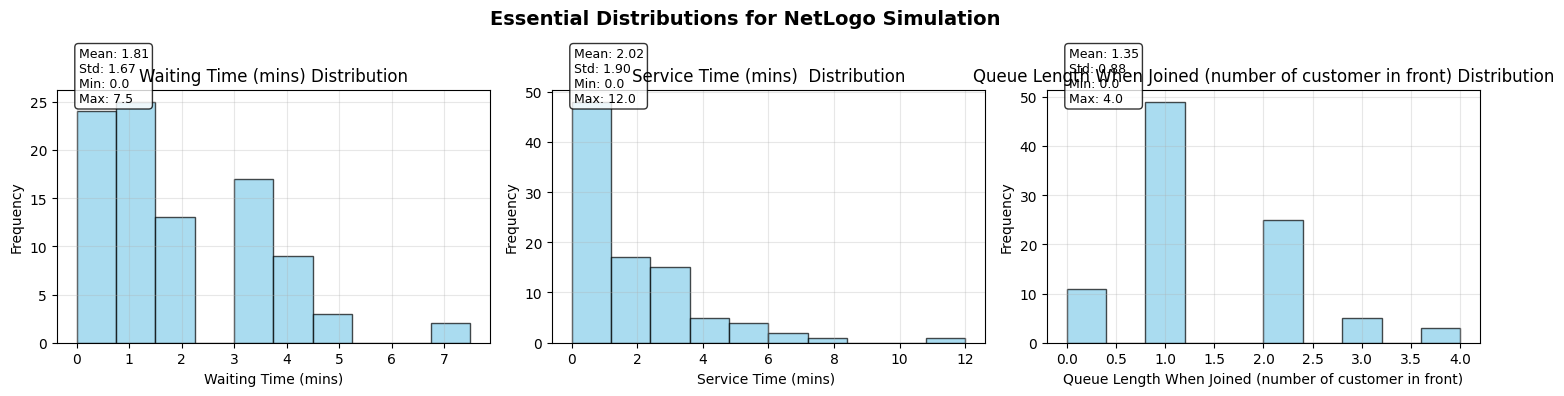


=== SIMPLE DISTRIBUTION SUMMARY ===
Variable                                     Mean      Std       Min       Max       Suggested Distribution
-------------------------------------------------------------------------------------------------------------------
Waiting Time (mins)                           1.81      1.67      0.0       7.5       Gamma/Normal
Service Time (mins)                           2.02      1.90      0.0       12.0      Gamma/Normal
Queue Length When Joined (number of customer in front) 1.35      0.88      0.0       4.0       Gamma/Normal

=== ARRIVAL TIME ANALYSIS (CRITICAL FOR SIMULATION) ===


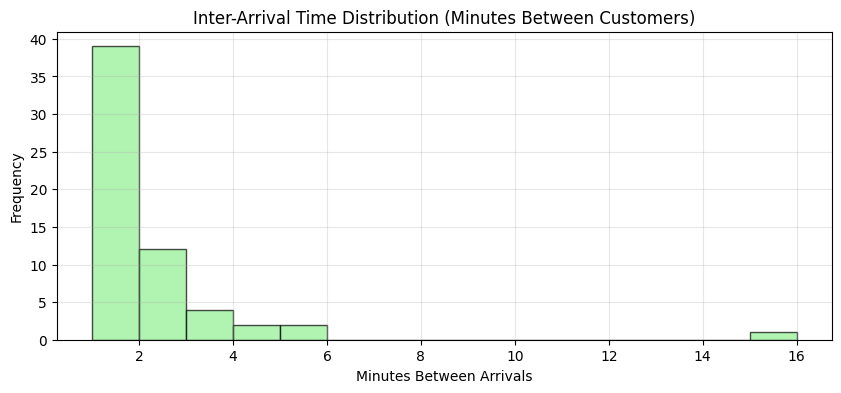

Inter-Arrival Time Statistics:
Mean: 1.82 minutes
Std: 2.11 minutes
Min: 1.00 minutes
Max: 16.00 minutes
Suggested: Exponential distribution with mean 1.82

;; NetLogo arrival rate parameter:
let arrival_rate 0.550  ; customers per minute
let mean_interarrival_time 1.82

=== QUICK RECOMMENDATIONS ===
1. Arrival Process: Use exponential distribution for inter-arrival times
2. Service Times: Use normal/gamma distribution based on basket type
3. Queue Length: Use observed min/max for random uniform
4. Waiting Times: Use exponential/normal based on patience modeling


In [ ]:
print("\n=== ESSENTIAL DISTRIBUTIONS FOR NETLOGO RANDOM NUMBERS ===")

# Key variables for NetLogo simulation randomness
key_variables = [
    'Waiting Time (mins)',      # For customer patience
    'Service Time (mins) ',      # For service duration
    'Queue Length When Joined (number of customer in front)', # For queue length distribution
]

# Simple distribution analysis
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Essential Distributions for NetLogo Simulation', fontsize=14, fontweight='bold')

for i, var in enumerate(key_variables):
    if var in df_clean.columns:
        data = df_clean[var].dropna()

        if len(data) > 0:
            # Simple histogram
            axes[i].hist(data, bins=10, alpha=0.7, color='skyblue', edgecolor='black')
            axes[i].set_title(f'{var} Distribution')
            axes[i].set_xlabel(var)
            axes[i].set_ylabel('Frequency')
            axes[i].grid(True, alpha=0.3)

            # Add basic stats on the plot
            axes[i].text(0.05, 0.95, f'Mean: {data.mean():.2f}\nStd: {data.std():.2f}\nMin: {data.min():.1f}\nMax: {data.max():.1f}',
                        transform=axes[i].transAxes, fontsize=9,
                        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.tight_layout()
plt.show()

print("\n=== SIMPLE DISTRIBUTION SUMMARY ===")
print("Variable".ljust(45) + "Mean".ljust(10) + "Std".ljust(10) + "Min".ljust(10) + "Max".ljust(10) + "Suggested Distribution")
print("-" * 115)

for var in key_variables:
    if var in df_clean.columns:
        data = df_clean[var].dropna()
        if len(data) > 0:
            mean_val = data.mean()
            std_val = data.std()
            cv = std_val / mean_val if mean_val != 0 else 0  # Coefficient of variation

            # Simple distribution recommendation
            if cv >= 1.0:
                dist_type = "Exponential"
            elif cv >= 0.5:
                dist_type = "Gamma/Normal"
            else:
                dist_type = "Normal/Uniform"

            print(f"{var:<45} {mean_val:<9.2f} {std_val:<9.2f} {data.min():<9.1f} {data.max():<9.1f} {dist_type}")


print("\n=== ARRIVAL TIME ANALYSIS (CRITICAL FOR SIMULATION) ===")
if 'Time Enter Queue' in df_clean.columns:
    # Calculate inter-arrival times
    df_time_sorted = df_clean.sort_values('Time Enter Queue').dropna(subset=['Time Enter Queue'])

    if len(df_time_sorted) > 1:
        arrival_times = df_time_sorted['Time Enter Queue']
        inter_arrival_times = []

        for i in range(1, len(arrival_times)):
            time_diff = (arrival_times.iloc[i] - arrival_times.iloc[i-1]).total_seconds() / 60.0
            if time_diff > 0:  # Only positive time differences
                inter_arrival_times.append(time_diff)

        if inter_arrival_times:
            inter_arrival_series = pd.Series(inter_arrival_times)

            plt.figure(figsize=(10, 4))
            plt.hist(inter_arrival_series, bins=15, alpha=0.7, color='lightgreen', edgecolor='black')
            plt.title('Inter-Arrival Time Distribution (Minutes Between Customers)')
            plt.xlabel('Minutes Between Arrivals')
            plt.ylabel('Frequency')
            plt.grid(True, alpha=0.3)
            plt.show()

            print(f"Inter-Arrival Time Statistics:")
            print(f"Mean: {inter_arrival_series.mean():.2f} minutes")
            print(f"Std: {inter_arrival_series.std():.2f} minutes")
            print(f"Min: {inter_arrival_series.min():.2f} minutes")
            print(f"Max: {inter_arrival_series.max():.2f} minutes")
            print(f"Suggested: Exponential distribution with mean {inter_arrival_series.mean():.2f}")
            print("")
            print(";; NetLogo arrival rate parameter:")
            print(f"let arrival_rate {1.0 / inter_arrival_series.mean():.3f}  ; customers per minute")
            print(f"let mean_interarrival_time {inter_arrival_series.mean():.2f}")

print("\n=== QUICK RECOMMENDATIONS ===")
print("1. Arrival Process: Use exponential distribution for inter-arrival times")
print("2. Service Times: Use normal/gamma distribution based on basket type")
print("3. Queue Length: Use observed min/max for random uniform")
print("4. Waiting Times: Use exponential/normal based on patience modeling")

**Time Analysis**

In [ ]:
# Additional detailed analysis
print("\n=== DETAILED TIME ANALYSIS ===")

# Time-based analysis
if 'Time Enter Queue' in df_clean.columns:
    df_clean['Hour Entered'] = df_clean['Time Enter Queue'].dt.hour
    df_clean['Minute Entered'] = df_clean['Time Enter Queue'].dt.minute

    hourly_stats = df_clean.groupby('Hour Entered').agg({
        'Customer ID': 'count',
        'Waiting Time (mins)': 'mean',
        'Service Time (mins) ': 'mean',
        'Queue Length When Joined (number of customer in front)': 'mean'
    }).round(2)

    print("Hourly performance metrics:")
    print(hourly_stats)



=== DETAILED TIME ANALYSIS ===
Hourly performance metrics:
              Customer ID  Waiting Time (mins)  Service Time (mins)   \
Hour Entered                                                           
15                     27                 1.54                  1.96   
16                     60                 2.01                  2.13   
17                      6                 1.00                  1.17   

              Queue Length When Joined (number of customer in front)  
Hour Entered                                                          
15                                                         1.26       
16                                                         1.43       
17                                                         1.00       


**Correlation Analysis**


=== CORRELATION ANALYSIS ===
Correlation Matrix:
                                                    Queue Length When Joined (number of customer in front)  \
Queue Length When Joined (number of customer in...                                           1.000000        
Waiting Time (mins)                                                                          0.485805        
Service Time (mins)                                                                         -0.050116        
Number of Staff                                                                             -0.144745        

                                                    Waiting Time (mins)  \
Queue Length When Joined (number of customer in...             0.485805   
Waiting Time (mins)                                            1.000000   
Service Time (mins)                                            0.136291   
Number of Staff                                               -0.071778   

                       

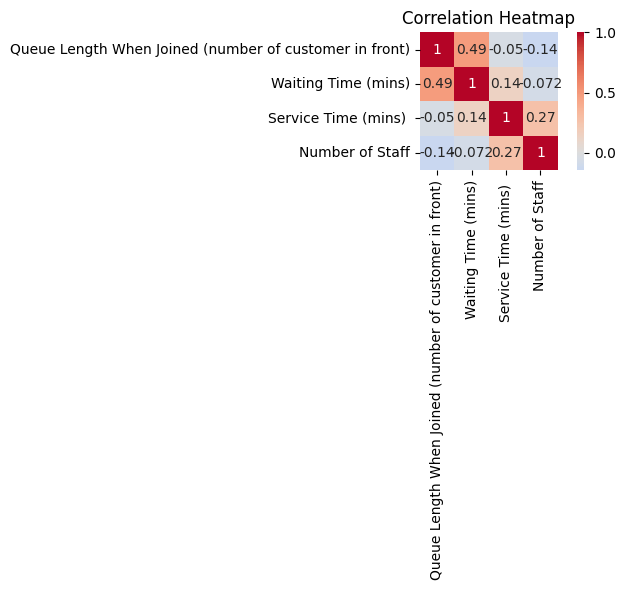

In [ ]:
# Correlation analysis
print("\n=== CORRELATION ANALYSIS ===")
numeric_columns = ['Queue Length When Joined (number of customer in front)', 'Waiting Time (mins)', 'Service Time (mins) ', 'Number of Staff']
numeric_df = df_clean[numeric_columns].select_dtypes(include=[np.number])

if not numeric_df.empty:
    correlation_matrix = numeric_df.corr()
    print("Correlation Matrix:")
    print(correlation_matrix)

    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, square=True)
    plt.title('Correlation Heatmap')
    plt.tight_layout()
    plt.show()


=== SPECIAL CASES ANALYSIS ===
Group payments found: 9
Group payment statistics:
       Waiting Time (mins)  Service Time (mins) 
count             9.000000              9.000000
mean              1.666667              2.222222
std               1.414214              2.166667
min               0.000000              0.000000
25%               1.000000              1.000000
50%               1.000000              1.000000
75%               3.000000              3.000000
max               4.000000              7.000000

MyKasih counter analysis (47 customers):
Average waiting time: 2.16 mins
Average service time: 2.70 mins
Most common payment method: Cash

Counter Type Comparison:
             Waiting Time (mins)       Service Time (mins)         \
                            mean   std                 mean   std   
Counter Type                                                        
MyKasih                     2.16  1.69                 2.70  2.17   
Normal                      1.45  1.

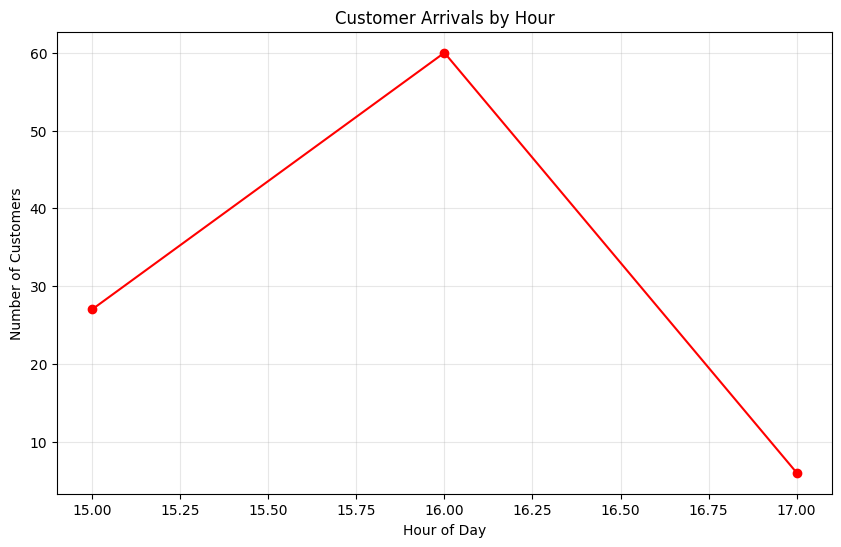

Busiest hours:
Hour 15:00 - 27 customers
Hour 16:00 - 60 customers
Hour 17:00 - 6 customers

=== SERVICE EFFICIENCY ANALYSIS ===
Counter Efficiency Metrics:
                Customer ID  Service Time (mins)   Waiting Time (mins)  \
Counter Number                                                           
4.0                      46                  1.33                 1.45   
10.0                     19                  2.21                 1.58   
11.0                     28                  3.04                 2.55   

                Queue Length When Joined (number of customer in front)  \
Counter Number                                                           
4.0                                                          1.57        
10.0                                                         1.05        
11.0                                                         1.21        

                Customers per Hour  
Counter Number                      
4.0                        

In [ ]:
# Special cases analysis
print("\n=== SPECIAL CASES ANALYSIS ===")

# Group payments analysis
group_payments = df_clean[df_clean['Customer Behavior / Notes'].str.contains('group payment', na=False)]
if not group_payments.empty:
    print(f"Group payments found: {len(group_payments)}")
    print("Group payment statistics:")
    print(group_payments[['Waiting Time (mins)', 'Service Time (mins) ']].describe())

# MyKasih specific analysis
mykasih_data = df_clean[df_clean['Counter Type'] == 'MyKasih']
if not mykasih_data.empty:
    print(f"\nMyKasih counter analysis ({len(mykasih_data)} customers):")
    print(f"Average waiting time: {mykasih_data['Waiting Time (mins)'].mean():.2f} mins")
    print(f"Average service time: {mykasih_data['Service Time (mins) '].mean():.2f} mins")
    print(f"Most common payment method: {mykasih_data['Payment Method'].mode().iloc[0] if not mykasih_data['Payment Method'].mode().empty else 'N/A'}")

# Express vs Normal counter comparison
if 'Counter Type' in df_clean.columns:
    counter_comparison = df_clean.groupby('Counter Type').agg({
        'Waiting Time (mins)': ['mean', 'std'],
        'Service Time (mins) ': ['mean', 'std'],
        'Queue Length When Joined (number of customer in front)': ['mean', 'max'],
        'Customer ID': 'count'
    }).round(2)

    print("\nCounter Type Comparison:")
    print(counter_comparison)

# Peak hour analysis
print("\n=== PEAK HOUR ANALYSIS ===")
if 'Hour Entered' in df_clean.columns:
    peak_hours = df_clean['Hour Entered'].value_counts().sort_index()
    plt.figure(figsize=(10, 6))
    peak_hours.plot(kind='line', marker='o', color='red')
    plt.title('Customer Arrivals by Hour')
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Customers')
    plt.grid(True, alpha=0.3)
    plt.show()

    print("Busiest hours:")
    for hour, count in peak_hours.items():
        print(f"Hour {hour}:00 - {count} customers")

# Service efficiency analysis
print("\n=== SERVICE EFFICIENCY ANALYSIS ===")
efficiency_metrics = df_clean.groupby('Counter Number').agg({
    'Customer ID': 'count',
    'Service Time (mins) ': 'mean',
    'Waiting Time (mins)': 'mean',
    'Queue Length When Joined (number of customer in front)': 'mean'
}).round(2)

efficiency_metrics['Customers per Hour'] = (efficiency_metrics['Customer ID'] / 1.5).round(1)  # Assuming 1.5 hours observation
print("Counter Efficiency Metrics:")
print(efficiency_metrics)

print("\n=== KEY INSIGHTS SUMMARY ===")
print(f"1. Total customers observed: {len(df_clean)}")
print(f"2. Average waiting time: {df_clean['Waiting Time (mins)'].mean():.2f} minutes")
print(f"3. Average service time: {df_clean['Service Time (mins) '].mean():.2f} minutes")
print(f"4. Most common basket type: {df_clean['Basket Type'].mode().iloc[0] if not df_clean['Basket Type'].mode().empty else 'N/A'}")
print(f"5. Most popular payment method: {df_clean['Payment Method'].mode().iloc[0] if not df_clean['Payment Method'].mode().empty else 'N/A'}")
print(f"6. Average queue length when joining: {df_clean['Queue Length When Joined (number of customer in front)'].mean():.2f} customers")



In [ ]:
# Save cleaned data
df_clean.to_csv('Lotus_Observation_Cleaned.csv', index=False)
print(f"\nCleaned data saved to 'Lotus_Observation_Cleaned.csv'")


Cleaned data saved to 'Lotus_Observation_Cleaned.csv'
